In [1]:
from tools.FileParser import FileParser as FP

/home/nbuser/anaconda3_501/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/nbuser/anaconda3_501/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Load a file
Using the **Data** menu at the top of the notebook

Data --> Upload

Copy the file link that it returns (e.g. /home/nbuser/vtg_log7_wheel.csv)

In [2]:
data = FP.openFile("/home/nbuser/vtg_log7_wheel.csv")

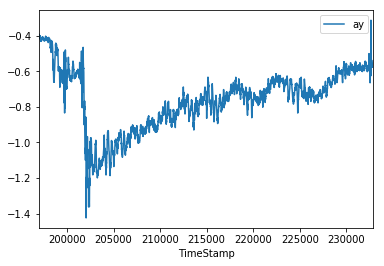

In [8]:
%matplotlib inline

data[1].plot(x='TimeStamp',y='ay')

In [4]:
data[1]

,TimeStamp,Data_Type,ax,ay,az,rx,ry,rz
0,196950,2,-0.215820,-0.417480,0.882324,-0.975610,2.926829,0.548781
2,196960,2,-0.213867,-0.403809,0.864258,-0.792683,1.951220,0.182927
4,196970,2,-0.210938,-0.407227,0.863770,-0.914634,1.951220,0.365854
6,196980,2,-0.219238,-0.398438,0.865234,-0.975610,1.707317,0.548781
8,196990,2,-0.209473,-0.396973,0.862793,-1.158537,1.036585,0.975610
10,197000,2,-0.212402,-0.414551,0.871582,-1.463415,0.914634,1.341463
12,197010,2,-0.209961,-0.392090,0.873535,-1.463415,0.609756,1.341463
14,197020,2,-0.212891,-0.396973,0.867676,-1.524390,0.182927,1.341463
16,197030,2,-0.204102,-0.396973,0.884277,-1.463415,0.000000,1.402439
18,197040,2,-0.208496,-0.403320,0.871582,-1.646341,-0.060976,1.707317
